# Najibe Sadati (Sample Code for Binary Classification)


In [21]:
# load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
import collections
import numpy as np
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import math
from matplotlib import pyplot as plt
import collections
import shap
import os
import warnings
warnings.filterwarnings('ignore')

# set work directory that the data is there
path = '....\\Binary_clf_sample'
os.chdir(path)  # set the WD

In [12]:
#-----------------------------------------------------------------------------------------------------------------------
# Required Functions
#----------------------------------------------------------------------------------------------------------------------- 

def missing_values_imputer(x):
    # define imputer
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    imputer.fit(x)
    
    return imputer


# Oversampling and under-sampleing using SMOTEENN 
def get_oversampling_SMOTEENN (x, y):
    smote_enn = SMOTEENN(random_state=0)
    X_resampled, y_resampled = smote_enn.fit_resample(x, y)
    y_resampled = pd.Series(y_resampled)
    X_resampled= pd.DataFrame(X_resampled, columns=x.columns)
    original_fraction = np.sum(y)/ len(y)
    oversampled_fraction = np.sum(y_resampled) / len(y_resampled)
        
    return X_resampled, y_resampled, original_fraction, oversampled_fraction


# Categoricl to dummy encoder
def cat_fit(x):
    encoders = collections.defaultdict(LabelEncoder)
    df_cat_cols = x.select_dtypes(include=['object'])
    for col in df_cat_cols.columns:
        encoders[col].fit(df_cat_cols[col])

    return encoders

def cat_transform(x, encoders):
    x_new = x.copy()
    df_cat_cols = x_new.select_dtypes(include=['object'])
    for col in df_cat_cols.columns:
        label_exists_flag = x_new[col].isin(encoders[col].classes_)
        x_new.loc[label_exists_flag, col] = encoders[col].transform(x_new.loc[label_exists_flag, col])
        x_new.loc[~label_exists_flag, col] = -1 # if the category does not exist in the fitted one

    return x_new

def get_data_with_feature_selection(file_name, path):
    os.chdir(path)
    df = pd.read_csv(file_name)
    # Reset the index
    df = df.reset_index()
    df = df.drop('index', 1)
    # Extract X and y
    X = df.drop("Call_Flag", 1)
    y = df['Call_Flag']
    # change the date column to name of week days
    X['DATE_FOR'] = pd.to_datetime(X['DATE_FOR'])
    X['DATE_FOR'] = X['DATE_FOR'].dt.day_name()
    # feature selecttion
    # label encoder for categorical features
    encoders_import=cat_fit(x=X)
    # tranform X
    X_import=cat_transform(x=X, encoders=encoders_import)
    # build xgboost model 
    xgbst = XGBClassifier(booster='gbtree', seed=0, colsample_bylevel=1, gamma=0.5, learning_rate=0.1, max_depth=7,
                          min_child_weight=3, n_estimators=100, reg_lambda=1,scale_pos_weight=len(y) / sum(y), n_jobs=-1)

    # feature importance using SHAP approach
    explainer = shap.TreeExplainer(xgbst.fit(X_import, y))
    shap_values = explainer.shap_values(X_import)
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame([X_import.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False)
    importance_df = importance_df[importance_df['shap_importance'] > 0.1]
    shap.summary_plot(shap_values, X_import, plot_type="bar")
    shap.summary_plot(shap_values, X_import)
    selected_features = importance_df['column_name'].tolist()
    # finalize X
    X = X[selected_features]
    # capture categorical feature
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    # capture the binary columns 
    bool_cols = [col for col in X if np.isin(X[col].dropna().unique(), [0, 1]).all()]
    # cat and bool cols as one list
    cat_cols = cat_cols+bool_cols

    return X,y, cat_cols

[18:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


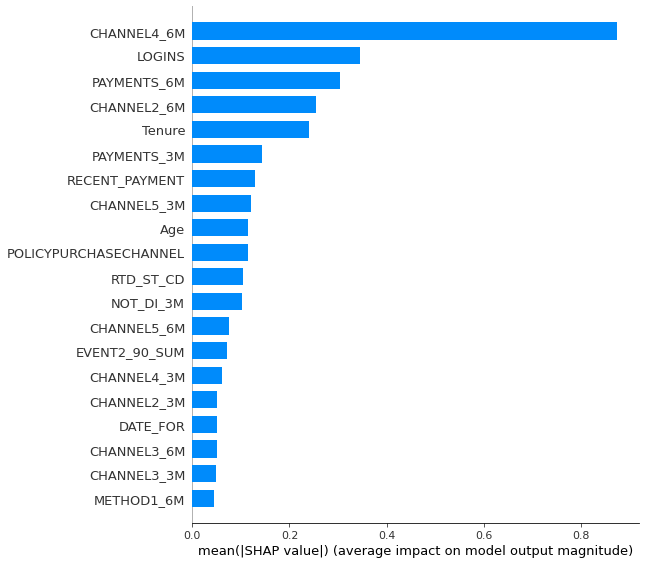

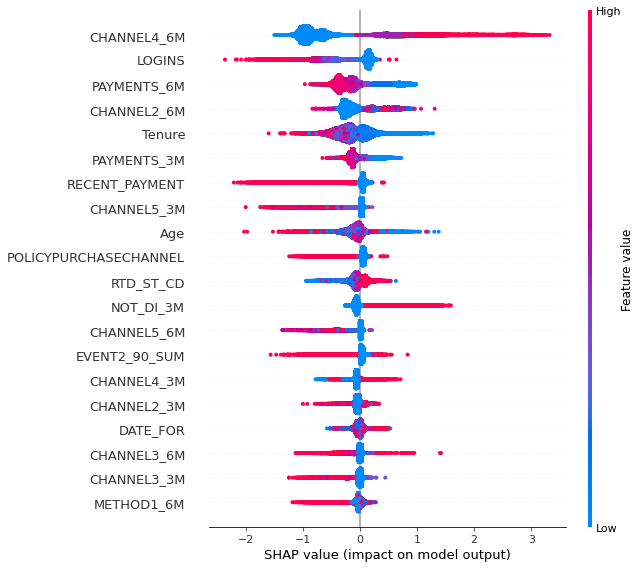

In [13]:
# get data and feature selection using SHAP
X,y, cat_cols= get_data_with_feature_selection(file_name="data.csv", path=path )

In [14]:
# Final features
print(X.columns.tolist())

['CHANNEL4_6M', 'LOGINS', 'PAYMENTS_6M', 'CHANNEL2_6M', 'Tenure', 'PAYMENTS_3M', 'RECENT_PAYMENT', 'CHANNEL5_3M', 'Age', 'POLICYPURCHASECHANNEL', 'RTD_ST_CD', 'NOT_DI_3M']


# 5 Top features interaction  plots

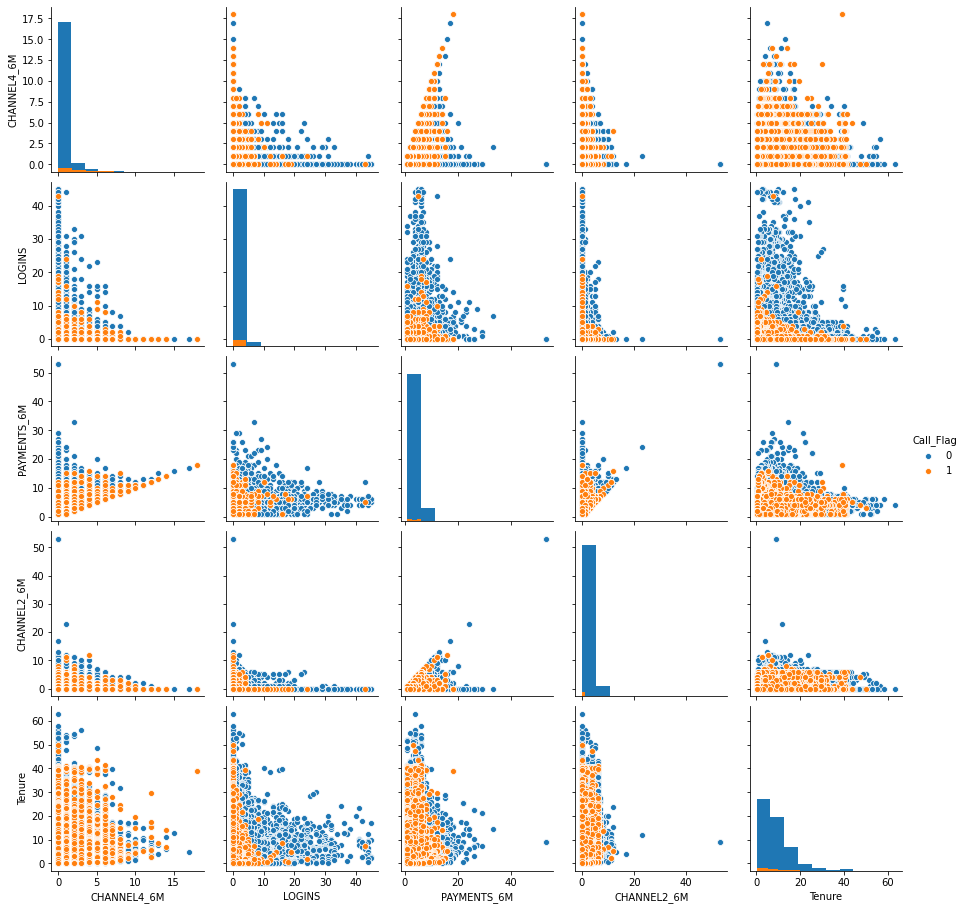

In [20]:
# reading data
df = pd.read_csv("data.csv")
# Reset the index
df = df.reset_index()
df = df.drop('index', 1)
# Extract X and y
X = df.drop("Call_Flag", 1)
y = df['Call_Flag']
# change the date column to name of week days
X['DATE_FOR'] = pd.to_datetime(X['DATE_FOR'])
X['DATE_FOR'] = X['DATE_FOR'].dt.day_name()
# feature selecttion
# label encoder for categorical features
encoders_import=cat_fit(x=X)
# tranform X
X_import=cat_transform(x=X, encoders=encoders_import)
# only plotting for top 5 features
X_plot = X_import[['CHANNEL4_6M', 'LOGINS', 'PAYMENTS_6M', 'CHANNEL2_6M', 'Tenure']]
X_plot['Call_Flag']=y

import seaborn as sns

sns.pairplot(X_plot, hue="Call_Flag", diag_kind="hist")

# XGBoost Model

In [15]:
#-----------------------------------------------------------------------------------------------------------------------
# Cross validation to evaluate the performance of the model and hyper-parameter tuning
#-----------------------------------------------------------------------------------------------------------------------
threshold = 0.4
# cross validation with shuffling
indx = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=100)

# DataFrame for keeping the results
df_results_XGB=  pd.DataFrame(columns=['precision_pass_test', 'precision_fail_test', 'recall_pass_test','recall_fail_test',
                                       'F-score_pass_test', 'F-score_fail_test',
                                       'ROC_train', 'ROC_test', 'Acc_train', 'Acc_test'])

for train_index, test_index in indx.split(X, y):
    
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # label encoder for categorical features
    encoders_X=cat_fit(x=X_train)
    
    # tranform cat_to_dummies X_train and X_test
    X_train=cat_transform(x=X_train, encoders=encoders_X)
    X_test=cat_transform(x=X_test, encoders=encoders_X)
    
    # imputing missing values using KNN (fitting on train)
    imputer_X=missing_values_imputer(x=X_train)
    # imputting on train and test
    X_train = pd.DataFrame(imputer_X.transform(X_train), columns =X_train.columns)
    X_test = pd.DataFrame(imputer_X.transform(X_test), columns =X_test.columns)    
    
    # reset index
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)    
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)    
       
    # over_under sampling only on train data
    X_train, y_train, original_fraction, oversampled_fraction = get_oversampling_SMOTEENN(x=X_train, y=y_train)

    print (original_fraction, oversampled_fraction)
    
    # Building the ML model
    xgbmodel = XGBClassifier(booster='gbtree', seed=0, nthread=-1,objective='binary:logistic', n_jobs=-1)
    param_grid = {'max_depth': [7, 9],
                  'learning_rate': [0.1, 1],
                  'reg_lambda': [1],
                  'min_child_weight': [5],
                  'n_estimators': [100,300],
                  'colsample_bylevel': [0.9],
                  'subsample':[0.9] }

    grid = GridSearchCV(estimator=xgbmodel,
                        param_grid=param_grid,
                        scoring='average_precision',
                        cv=3, verbose=True, n_jobs=-1)

    grid.fit(X_train, y_train, early_stopping_rounds=5, eval_metric=['map', 'auc'], eval_set=[(X_test, y_test)],verbose=False)

    # Training
    clf = grid.best_estimator_
    y_prob_train = clf.predict_proba(X_train)[:, 1]

    # the binary prediction based on threshold on train
    y_pred_train = (y_prob_train >= threshold).astype(int)

    # Testing
    y_prob_test = clf.predict_proba(X_test)[:, 1]
    # the binary prediction based on threshold on test
    y_pred_test = (y_prob_test >= threshold).astype(int)

    target_names = ['pass', 'fail']
    print ('Training results----------------------------------------')
    print(classification_report(y_train, y_pred_train, target_names=target_names))
    precision_train, recall_train, fscore_train, support_train = score(y_train, y_pred_train)
    conf_train = confusion_matrix(y_train, y_pred_train)
    
    print(pd.DataFrame(conf_train))
    Acc_train = sum(np.diagonal(conf_train)) / np.sum(conf_train)


    target_names = ['pass', 'fail']
    print ('Validation results--------------------------------------')
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    precision_test, recall_test, fscore_test, support_test = score(y_test, y_pred_test)
    conf_test = confusion_matrix(y_test, y_pred_test)

    print(pd.DataFrame(conf_test))
    Acc_test = sum(np.diagonal(conf_test)) / np.sum(conf_test)

    # the best parameters
    print(grid.best_params_)

    df_results_XGB = df_results_XGB.append(pd.Series([precision_test[0], precision_test[1], recall_test[0], recall_test[1], 
                                                      fscore_test[0], fscore_test[1],
                                                      roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]), 
                                                      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]), 
                                                      Acc_train, Acc_test], index=df_results_XGB.columns), ignore_index=True)

# save the all results in a csv file
df_results_XGB.to_csv('df_results_XGB.csv')

0.03662546870862766 0.5406054474555295
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Training results----------------------------------------
              precision    recall  f1-score   support

        pass       0.95      0.90      0.92     93541
        fail       0.92      0.96      0.94    110077

    accuracy                           0.93    203618
   macro avg       0.94      0.93      0.93    203618
weighted avg       0.93      0.93      0.93    203618

       0       1
0  83960    9581
1   4107  105970
Validation results--------------------------------------
              precision    recall  f1-score   support

        pass       0.99      0.85      0.91     12533
        fail       0.14      0.67      0.23       476

    accuracy                           0.84     13009
   macro avg       0.56      0.76      0.57     13009
weighted avg       0.95      0.84      0.89     13009

       0     1
0  10617  1916
1    158   318
{'colsample_bylevel': 0.9, 'learning_

       0       1
0  88583    5069
1   3686  106475
Validation results--------------------------------------
              precision    recall  f1-score   support

        pass       0.98      0.90      0.94     12533
        fail       0.18      0.55      0.27       476

    accuracy                           0.89     13009
   macro avg       0.58      0.73      0.60     13009
weighted avg       0.95      0.89      0.92     13009

       0     1
0  11311  1222
1    213   263
{'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 0.9}
0.03662546870862766 0.5410112304351671
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Training results----------------------------------------
              precision    recall  f1-score   support

        pass       0.94      0.95      0.95     93429
        fail       0.95      0.95      0.95    110125

    accuracy                           0.95    203554
  

In [16]:
# XGBoost ---> Summary of results over 10 runs
df_results_XGB

,precision_pass_test,precision_fail_test,recall_pass_test,recall_fail_test,F-score_pass_test,F-score_fail_test,ROC_train,ROC_test,Acc_train,Acc_test
0,0.985336,0.142346,0.847124,0.668067,0.911018,0.234686,0.982817,0.855391,0.932776,0.840572
1,0.984510,0.189001,0.897630,0.628151,0.939065,0.290573,0.991065,0.874435,0.955091,0.887770
2,0.982482,0.185386,0.903934,0.575630,0.941572,0.280450,0.991974,0.853710,0.958786,0.891921
3,0.984158,0.179721,0.892205,0.621849,0.935928,0.278851,0.990218,0.866843,0.953545,0.882312
4,0.983487,0.190286,0.902896,0.600840,0.941470,0.289035,0.991685,0.863249,0.957680,0.891844
5,0.982839,0.188987,0.904811,0.584034,0.942213,0.285568,0.991242,0.857498,0.956801,0.893074
6,0.983672,0.185733,0.898907,0.607143,0.939381,0.284449,0.990387,0.860399,0.954599,0.888231
7,0.981517,0.177104,0.902497,0.552521,0.940350,0.268230,0.991166,0.846364,0.957044,0.889692
8,0.981747,0.176862,0.901221,0.558824,0.939762,0.268687,0.987373,0.852570,0.949664,0.888692
9,0.983374,0.174893,0.891965,0.602941,0.935442,0.271138,0.990658,0.848482,0.953825,0.881390


# Logistic Regreesion 

In [17]:
#-----------------------------------------------------------------------------------------------------------------------
# Cross validation to evaluate the performance of the model and hyper-parameter tunning
#-----------------------------------------------------------------------------------------------------------------------
threshold = 0.4
# cross validation with shuffling
indx = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=100)

# DataFrame for saving the results
df_results_LR=  pd.DataFrame(columns=['precision_pass_test', 'precision_fail_test', 'recall_pass_test','recall_fail_test',
                                       'F-score_pass_test', 'F-score_fail_test',
                                       'ROC_train', 'ROC_test', 'Acc_train', 'Acc_test'])

for train_index, test_index in indx.split(X, y):
    
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # label encoder for categorical features
    encoders_X=cat_fit(x=X_train)
    
    # tranform cat_to_dummies X_train and X_test
    X_train=cat_transform(x=X_train, encoders=encoders_X)
    X_test=cat_transform(x=X_test, encoders=encoders_X)
    
    # imputing missing values using KNN (fitting on train)
    imputer_X=missing_values_imputer(x=X_train)
    # imputting on train and test
    X_train = pd.DataFrame(imputer_X.transform(X_train), columns =X_train.columns)
    X_test = pd.DataFrame(imputer_X.transform(X_test), columns =X_test.columns)    
    
    # reset index
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)    
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)    
       
    # over_under sampling only on train data
    X_train, y_train, original_fraction, oversampled_fraction = get_oversampling_SMOTEENN(x=X_train, y=y_train)

    print (original_fraction, oversampled_fraction)
    
    # Building the LR model
    grid= GridSearchCV(cv=3,estimator=LogisticRegression(intercept_scaling=1,
                 dual=False, fit_intercept=True, tol=0.0001, solver='lbfgs'),
                 param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l2']}, scoring='average_precision')
    
    grid.fit(X_train, y_train)

    # Training
    clf = grid.best_estimator_
    y_prob_train = clf.predict_proba(X_train)[:, 1]

     # the binary prediction based on threshold on train
    y_pred_train = (y_prob_train >= threshold).astype(int)

    # Testing
    y_prob_test = clf.predict_proba(X_test)[:, 1]

    # the binary prediction based on threshold on test
    y_pred_test = (y_prob_test >= threshold).astype(int)

    target_names = ['pass', 'fail']
    print ('Training results----------------------------------------')
    print(classification_report(y_train, y_pred_train, target_names=target_names))
    precision_train, recall_train, fscore_train, support_train = score(y_train, y_pred_train)
    conf_train = confusion_matrix(y_train, y_pred_train)
    
    print(pd.DataFrame(conf_train))
    Acc_train = sum(np.diagonal(conf_train)) / np.sum(conf_train)


    target_names = ['pass', 'fail']
    print ('Validation results--------------------------------------')
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    precision_test, recall_test, fscore_test, support_test = score(y_test, y_pred_test)
    conf_test = confusion_matrix(y_test, y_pred_test)
    
    print(pd.DataFrame(conf_test))
    Acc_test = sum(np.diagonal(conf_test)) / np.sum(conf_test)

    # the best parameters
    print('The best parameters of LR after tunning: '+ str(grid.best_params_))

    df_results_LR = df_results_LR.append(pd.Series([precision_test[0], precision_test[1], recall_test[0], recall_test[1], 
                                                      fscore_test[0], fscore_test[1],
                                                      roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]), 
                                                      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]), 
                                                      Acc_train, Acc_test], index=df_results_XGB.columns), ignore_index=True)

# save the all results in a csv file
df_results_LR.to_csv('df_results_LR.csv')

0.03662546870862766 0.5406054474555295
Training results----------------------------------------
              precision    recall  f1-score   support

        pass       0.88      0.71      0.78     93541
        fail       0.79      0.92      0.85    110077

    accuracy                           0.82    203618
   macro avg       0.83      0.81      0.82    203618
weighted avg       0.83      0.82      0.82    203618

       0       1
0  66264   27277
1   9068  101009
Validation results--------------------------------------
              precision    recall  f1-score   support

        pass       0.99      0.63      0.77     12533
        fail       0.08      0.87      0.15       476

    accuracy                           0.64     13009
   macro avg       0.54      0.75      0.46     13009
weighted avg       0.96      0.64      0.75     13009

      0     1
0  7888  4645
1    62   414
The best parameters of LR after tunning: {'C': 0.01, 'penalty': 'l2'}
0.03662546870862766 0.54106859

0.03662546870862766 0.5406431771734004
Training results----------------------------------------
              precision    recall  f1-score   support

        pass       0.88      0.71      0.79     93503
        fail       0.79      0.92      0.85    110049

    accuracy                           0.82    203552
   macro avg       0.83      0.81      0.82    203552
weighted avg       0.83      0.82      0.82    203552

       0       1
0  66639   26864
1   9237  100812
Validation results--------------------------------------
              precision    recall  f1-score   support

        pass       0.99      0.63      0.77     12533
        fail       0.08      0.86      0.15       476

    accuracy                           0.64     13009
   macro avg       0.54      0.75      0.46     13009
weighted avg       0.96      0.64      0.75     13009

      0     1
0  7868  4665
1    65   411
The best parameters of LR after tunning: {'C': 10, 'penalty': 'l2'}


In [18]:
# Logistic Regression ---> Summary of results over 10 runs
df_results_LR

,precision_pass_test,precision_fail_test,recall_pass_test,recall_fail_test,F-score_pass_test,F-score_fail_test,ROC_train,ROC_test,Acc_train,Acc_test
0,0.992201,0.081834,0.629378,0.869748,0.770200,0.149593,0.908061,0.847483,0.821504,0.638174
1,0.993972,0.084820,0.631533,0.899160,0.772346,0.155016,0.905460,0.862369,0.818134,0.641325
2,0.992200,0.081818,0.629299,0.869748,0.770140,0.149566,0.907281,0.846035,0.820530,0.638097
3,0.992919,0.084493,0.637756,0.880252,0.776660,0.154186,0.907580,0.857935,0.820898,0.646629
4,0.992650,0.083701,0.635762,0.876050,0.775097,0.152803,0.907533,0.852975,0.821917,0.644554
5,0.993122,0.083982,0.633607,0.884454,0.773637,0.153398,0.906261,0.855440,0.819866,0.642786
6,0.994050,0.083953,0.626506,0.901261,0.768598,0.153598,0.904340,0.863953,0.816787,0.636559
7,0.991351,0.082587,0.640150,0.852941,0.777950,0.150593,0.907328,0.841443,0.819168,0.647936
8,0.993358,0.081853,0.620522,0.890756,0.763874,0.149929,0.906117,0.852176,0.818766,0.630410
9,0.991806,0.080969,0.627783,0.863445,0.768885,0.148055,0.909370,0.841233,0.822645,0.636406
